In [1]:
import os
#Log all tensorflow messages except INFO and WARNING.
#Lower the log level to show tensorflow warnings or info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from emg_hom_iso_unbound import tools, sim_infrastructure, model_config

import numpy as np

from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt



import glob

_mm = 1e-3

# Basic model configuration

The electromyography (EMG) model presented in this repository is in detail described in the publication Mechtenberg, M and Schneider, A (2023), which is currently 
in the review process.

This notebook was created in order to demonstrate the usage of the EMG model implementation. 

The emg model is configured with the `emg_hom_iso_unbound.model_config` module. In this example
the config module is referenced by `model_config`. The root config object needs a muscle configuration
`model_config.muscle`, a electrode configuration `model_config.electrodes`, and a simulation time vector as constructor parameters.
In this chapter an example model configuration with one muscle fiber is shown.

First a muscle is configured with a single muscle fiber.

In [2]:
conf_muscle = model_config.muscle()

## Basic motor unit configuration
A muscle consists of multiple motor units `model_config.motorUnit`. As only one fiber will be simulated in this example,
only one motor unit is needed here. The motor unit object defines the default 
parameters for all muscle fibers that are part of the motor unit. Muscle fibers can overwrite these default parameters.
In the setup described here the motor unit parameters are:

1. the `currentSource` model resistances `Re`and `Ri`
2. the conduction velocity `v`.

The module provides a default motor unit configuration (compare with cell [[4]](#cell_4)) which can be changed by providing parameters to
the constructor method [[5](#cell_5)] . Or by overwriting the respective fields [[6](#cell_6)].
This behavior is demonstrated in case of the conduction velocity in cell [4-6]  

<a id="cell_4"></a>

In [3]:
motor_unit = model_config.motorUnit()
motor_unit

{
  "fibers": [],
  "currentSource": {
    "a": 96,
    "l": 1000,
    "b": -0.08,
    "sType": "rosenfalck_current_source"
  },
  "Re": 0.5,
  "Ri": 0.5,
  "v": 5,
  "sType": "motorUnit"
}

<a id="cell_5"></a>

In [4]:
motor_unit = model_config.motorUnit(v = 10)
motor_unit

{
  "fibers": [],
  "currentSource": {
    "a": 96,
    "l": 1000,
    "b": -0.08,
    "sType": "rosenfalck_current_source"
  },
  "Re": 0.5,
  "Ri": 0.5,
  "v": 10.0,
  "sType": "motorUnit"
}

<a id="cell_6"></a>

In [5]:
motor_unit.v = 5
motor_unit

{
  "fibers": [],
  "currentSource": {
    "a": 96,
    "l": 1000,
    "b": -0.08,
    "sType": "rosenfalck_current_source"
  },
  "Re": 0.5,
  "Ri": 0.5,
  "v": 5.0,
  "sType": "motorUnit"
}

## Adding a muscle fiber to a motor unit

In the following a muscle fiber with a length of $28\,$mm is added.
The innervation point is configured, such that it is not in the center of the muscle fiber.

In [6]:
motor_unit.fibers.append(model_config.muscleFiber())
motor_unit.fibers[0].L = 28*_mm
motor_unit.fibers[0].IP = motor_unit.fibers[0].L / 3

As the default motor unit parameters are not yet overwritten by the muscle fiber, the muscle fiber configuration currently
adopts the default motor unit parameters from the parent motor unit object.
When the default motor unit configuration is changed all muscle fibers are updated, if
they do not overwrite the default parameter.

 - conduction velocity parameters **before** motor unit parameter change:

In [7]:
print("motor_unit.v: {} \t muscle_fiber.v:{}".format(motor_unit.v, motor_unit.fibers[0].v))

motor_unit.v: 5.0 	 muscle_fiber.v:5.0


 - conduction velocity parameters **after** motor unit parameter change:

In [8]:
motor_unit.v = 6
print("motor_unit.v: {} \t muscle_fiber.v:{}".format(motor_unit.v, motor_unit.fibers[0].v))

motor_unit.v: 6.0 	 muscle_fiber.v:6.0


When the muscle fiber parameters are configured explicitly by
assigning them directly to the respective muscle fiber object fields,
the respective parameter field is disconnected from the parent configuration.
The disconnected parameter is no longer updated on changes in the parent motor unit configuration.

In [9]:
print("overwrite default motor unit")
motor_unit.fibers[0].v=3.5
motor_unit.v = 5
print("motor_unit.v: {} \t muscle_fiber.v:{}".format(motor_unit.v, motor_unit.fibers[0].v))

overwrite default motor unit
motor_unit.v: 5.0 	 muscle_fiber.v:3.5


## Muscle configuration
Once the motor unit is configured, it has to be added to the muscle configuration.

In [10]:
conf_muscle.motor_units.append(motor_unit)
conf_muscle

{
  "motor_units": [
    {
      "fibers": [
        {
          "IP": 0.009333333333333334,
          "L": 0.028,
          "origin_location": [
            [
              0.0
            ],
            [
              0.0
            ],
            [
              0.0
            ]
          ],
          "rotation": {
            "z": 0,
            "y": 0,
            "sType": "muscleFiberRotation"
          },
          "v": 3.5,
          "sType": "muscleFiber"
        }
      ],
      "currentSource": {
        "a": 96,
        "l": 1000,
        "b": -0.08,
        "sType": "rosenfalck_current_source"
      },
      "Re": 0.5,
      "Ri": 0.5,
      "v": 5.0,
      "sType": "motorUnit"
    }
  ],
  "sType": "muscle"
}

## Basic electrode configuration
Now that the muscle is configured. An electrode array is configured.
By default the electrode matrix is configured as grid. Therefore, only the electrode grid
parameters are needed. A 3-dimensional electrode array (62x20x6) is configured as follows.
If a grid configuration is not suitable for your setup please look into the [detailed electrode configuration description](##Electrode-position-configuration-options-in-detail) section within the [Appendix](#Appendix).

In [11]:
electrode_matrix = model_config.electrodes(   x = np.arange( -motor_unit.fibers[0].L*0.05 
                                                   , motor_unit.fibers[0].L*1.05 
                                                   , 0.0005)                     # 62
                                  , y = np.arange(-0.005, 0.005,   0.0005)       # 20
                                  , z = np.arange(-0.0015, 0.0015, 0.0005)       #  6
                  )

## Root configuration
The root configuration contains the muscle and electrode configuration, as well as the export options and the 
simulation time vector. The simulation time vector defines the points in time, for which electrode potentials are calculated.
Here a heuristic is applied in order to determine the simulation time duration.
**You should adjust the simulation time vector, depending on your simulation setup**.


<a id="cell_12"></a>

In [12]:
max_time = (motor_unit.fibers[0].L / 2 + 14e-3) / motor_unit.fibers[0].v
time = np.linspace(0, max_time, 10000)

root_conf = model_config.root(  muscle     = conf_muscle
    , time       = time
    , electrodes = electrode_matrix 
    , export_vtk = False
    , export_npz = True
)

# Simulating a model configuration
In order to run the simulation you need to define 
an export directory for the simulation results.

In [13]:
export_dir_path = os.path.join('.', 'introduction_output', 'demo_one_Fiber')

Than you can create simulation jobs based on the configuration by

In [14]:
simJobs = sim_infrastructure.simJobsByModelConfig(  
           config=root_conf
         , project_dir=export_dir_path, create_project_dir=True, force_project_overwrite=True)

and execute these simulation jobs with:

In [15]:
simJobs.execute_all()

  0%|          | 0/1 [00:00<?, ?it/s]

# Importing simulation results
The simulation results are all stored on the hard drive in the export directory.
In the export directory there is a directory for muscle fiber. The muscle fibers are identified by the 
motor unit index and the muscle fiber index. These indices refer to the positions in the respective 
configuration object lists. The configuration that was used for a simulation run is stored in the `config.json`
file. For more details on the configuration file please look into the section [Repeating simulations](##-Repeating-simulations) in the [Appendix](#Appendix).

In the demonstrated simulation configuration (cell [[12]](#cell_12)) the numpy export was configured.
In this setup the simulation results are exported in the [`.npz` file format](https://numpy.org/doc/stable/reference/generated/numpy.savez.html).
The electrode potentials over time, current source locations and current source strength over time are exported for each muscle fiber

In [16]:
res = glob.glob(export_dir_path + "/*idx_motor_unit_0 idx_muscle_fiber_0_1/electrode_potentials.npz")
str_result = res[0]

npz_res = np.load(str_result, mmap_mode='r')

print("fields in the results numpy file:")
for x in npz_res.files:
    print("\t" + x)

print("\nShape of the electrode potential array:")
npz_res["electrode_potentials"].shape

fields in the results numpy file:
	electrode_potentials
	source_location
	source_current

Shape of the electrode potential array:


(62, 20, 6, 10000)

Here a plot of the electrode potential at grid position (35, 10, 5) is plotted over time.

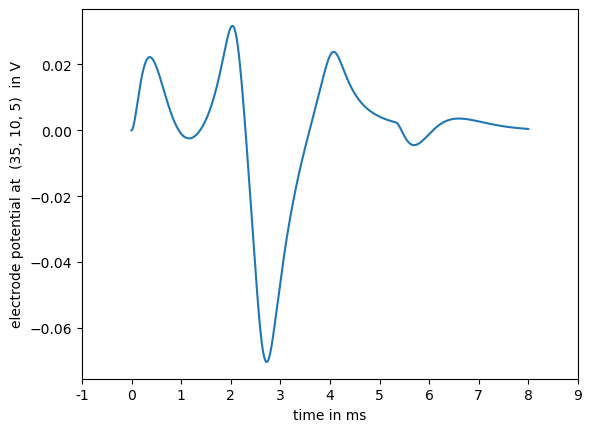

In [17]:
plt.figure()
plt.plot(time, npz_res["electrode_potentials"][35,10, 5,:])
ax = plt.gca()
ax.set_xticks(ax.get_xticks()) # only here to prevent matplotlib warning
ax.set_xticklabels("{:0.0f}".format(tick*1e3) for tick in ax.get_xticks())

_ = plt.xlabel("time in ms")
_ = plt.ylabel("electrode potential at  (35, 10, 5)  in V")

At this point you should know enough to build, run and import  your own simulations.
In the following section (the Appendix) the [electrode configuration interface](#Electrode-position-configuration-options-in-detail) is described in more detail.
There is also the description of 
[a tool for importing and post processing one dimensional electrode configuration simulations](#Tools-for-post-processing), that comes with this software package.
Additionally there is an example for the simulation of a [motor unit electrode potential with multiple muscle fibers](Example-motor-unit-setup), as well as a section 
which demonstrates the [repeated simulation of exported configurations](#Repeating-simulations).

# Appendix

## Electrode position configuration options in detail
Previously the electrode configuration in grid mode was demonstrated.
In the grid configuration mode only rectangular or cubic electrode arrays that are parallel to the
coordinate system axis can be simulated.

Therefore, it is recommended to configure the electrode positions via flattened NumPy arrays if
non grid configurations are needed. Note that the same electrode setup as above needs more computation time
if they are passed as flattened arrays.

In [18]:
x = np.arange( -motor_unit.fibers[0].L*0.05  , motor_unit.fibers[0].L*1.05  , 0.0005)
y = np.arange(-0.005, 0.005,   0.0005)
z = np.arange(-0.0015, 0.0015, 0.0005)

X, Y , Z = np.meshgrid(x,y,z, indexing='ij')

electrode_matrix = model_config.electrodes(
      x = X.flatten()
    , y = Y.flatten()
    , z = Z.flatten()
    , isGridConfig = False )

root_conf.electrodes = electrode_matrix

project_dir_path = os.path.join(".", "introduction_output", "demo_one_Fiber_flattened")
simJobs = sim_infrastructure.simJobsByModelConfig(  
           config=root_conf
         , project_dir = project_dir_path
         , create_project_dir=True
         , force_project_overwrite=True)

simJobs.execute_all()

  0%|          | 0/1 [00:00<?, ?it/s]

## Tools for post processing

If the simulation was run with a one dimensional electrode array there is a simulation 
result import and post processing tool available that can be used.
This tool is capable of 

- calculating single and double differential electrode recordings
- application of gaussian noise with configurable signal to noise ratio
- filtering
- plotting

In order to demonstrate this tool a simulation with a linear electrode array is configured.

In [19]:
project_dir_path = os.path.join(".", "introduction_output", "demo_one_Fiber_linear_array")

x = np.arange( -motor_unit.fibers[0].L*0.05  , motor_unit.fibers[0].L*1.05  , 0.0005)
y = np.array(0)
z = np.array(0.0015)

electrode_matrix = model_config.electrodes( x = x  , y = y  , z=z  , isGridConfig = True )

root_conf.electrodes = electrode_matrix

simJobs = sim_infrastructure. \
        simJobsByModelConfig(  
           config                  = root_conf
         , project_dir             = project_dir_path
         , create_project_dir      = True
         , force_project_overwrite = True)

simJobs.execute_all()

  0%|          | 0/1 [00:00<?, ?it/s]

In order to import the simulation results a pandas DataFrame is needed that links the 
muscle, motor unit and muscle fiber index to a `.npz` file. This DataFrame is created by:

In [20]:
glob_list = glob.glob("./introduction_output/demo_one_Fiber_linear_array/**/*.npz")
df_npz =  tools.generate_df_sim_res_muscles(glob_list)
df_npz

  0%|          | 0/1 [00:00<?, ?it/s]

,idx_muscle,idx_motor_unit,idx_muscle_fiber,idx_run,file_path,unique_idx_motor_unit
0,0,0,0,1,./introduction_output/demo_one_Fiber_linear_ar...,0


The simulation result object is than created by passing the project directory path, simulation result DataFrame and the muscle and motor unit index to the simulation result object
`tools.npz_sEMG_sim_results`.
The `unique_idx_motor_unit` field of the `df_npz` DataFrame is a combined key of `idx_motor_unit` and `idx_muscle which` allows to 
pass all muscle fiber simulation results that are part of a motor unit to the simulation result object.
The simulation result object automatically calculates the sum potential of all passed simulation results.
This is [later used](#Example-motor-unit-setup) in order to import motor unit sum potentials.

In [21]:
sim_res =  tools.npz_sEMG_sim_results(
      sim_project_dir = project_dir_path
    , npz_file_df     = df_npz[df_npz.unique_idx_motor_unit == 0]
    , idx_muscle      = 0
    , idx_motor_unit  = 0)

### plotting the simualtion results of a linear electrode array

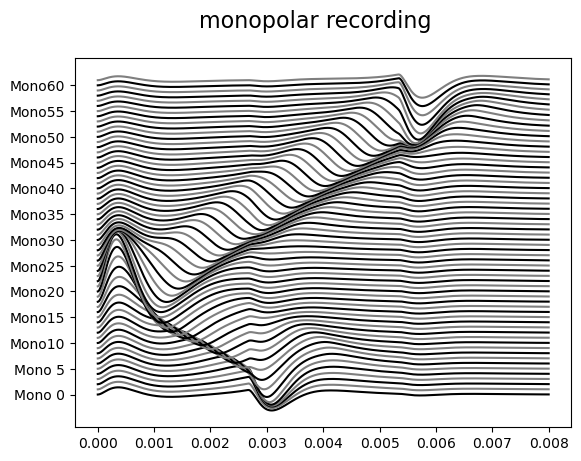

In [22]:
fig, ax =  tools.plotSum_df(sim_res.sum_df_Mono, delta=0.01, str_title="monopolar recording", str_y_label="Mono")
_ = ax.set_yticks(ax.get_yticks()[::5], minor=False)

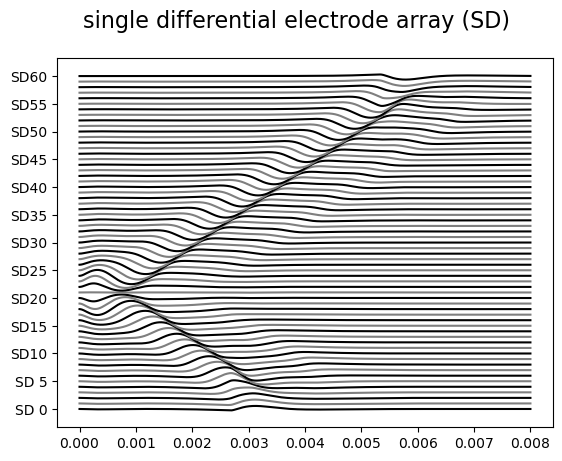

In [23]:
fig, ax =  tools.plotSum_df(sim_res.sum_df_SD, delta=0.01, every_nth_y_tick=5)

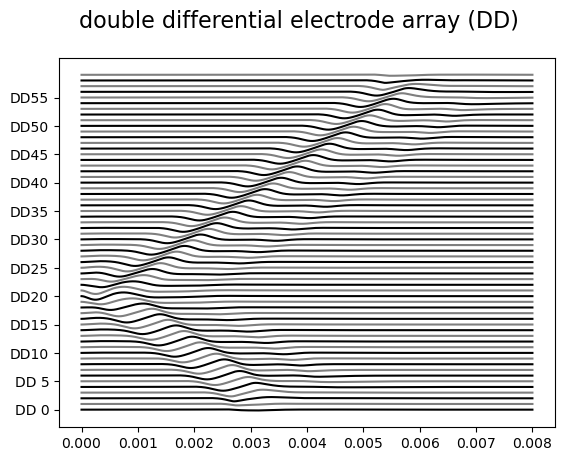

In [24]:
fig, ax =  tools.plotSum_df(sim_res.sum_df_DD, delta=0.01, str_y_label="DD", str_title="double differential electrode array (DD)", every_nth_y_tick=5)

### Additive gaussian Noise
The simulation result object allows the addition of guassian noise based on
a given signal to noise level.

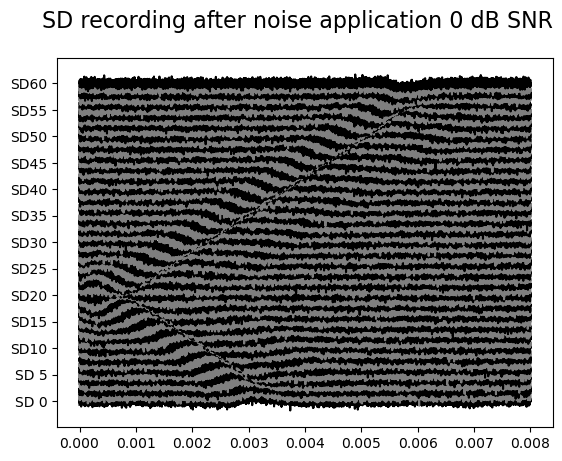

In [25]:
sim_res.calc_white_gaussian_sigma_dB_power_forSD(0)
fig, ax =  tools.plotSum_df(sim_res.sum_df_SD_addGausian, delta=0.01, every_nth_y_tick=5, str_title="SD recording after noise application 0 dB SNR")

It is also possible to apply filters form the `scipy.signal` package to the noisy data as follows.

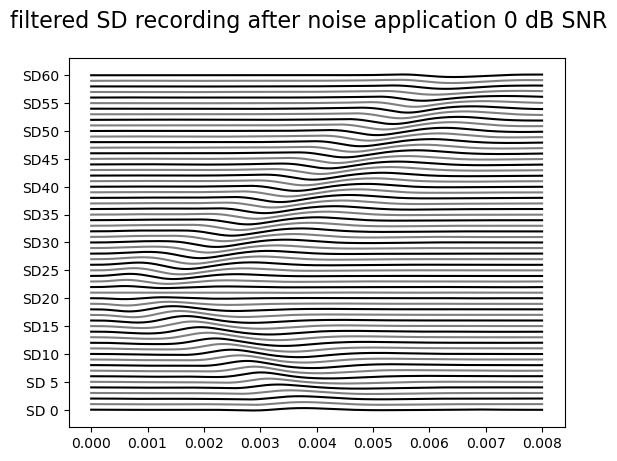

In [26]:
import scipy.signal

sim_res.sos_filterOn_SD(scipy.signal.butter, 2, [4,400], "bandpass")
_ = tools.plotSum_df(sim_res.sum_df_SD_addGausian_filtered, delta=0.01, every_nth_y_tick=5, str_title="filtered SD recording after noise application 0 dB SNR")

## Example motor unit setup
Here a motor unit with 800 muscle fibers is configured. The innervation points and muscle fiber end points are drawn from uniform
distributions and then exported as motor unit configuration for the present model.
These geometric parameters are configured similar to the method described in the publication Merletti, R et al. (1999). It is described in detail
by the publication Mechtenberg, M and Schneider, A (2023).

A detailed explanation of the parameters, supported by a figure, will be present here upon the acceptance and publication of Mechtenberg, M and Schneider, A (2023).

In [27]:
_mm  = 1e-3
_cm  = 1e-2
_cm2 = _cm**2
_m   = 1


N_mf = 800

A_R = 10 * _cm2
L_f = 15 * _cm

MU_gen_MF = (
    lambda : model_config.MF_Merletti1999(
      W_I = 2*_cm
    , L_L = L_f * 0.5
    , L_R = L_f * 0.5

    , W_TL = 0.5*_cm
    , W_TR = 0.5*_cm

    , R   = np.sqrt((A_R) / np.pi))
 )

conf_m    = model_config.muscle()
motorUnit = model_config.motorUnit()

max_L = 0

for idx_mf in tqdm(range(N_mf), desc="muscle_fiber", leave=False):
    mf = MU_gen_MF()
    if mf.L > max_L:
        max_L = mf.L

    motorUnit.fibers.append(mf)

conf_m.motor_units.append(motorUnit)

muscle_fiber:   0%|          | 0/800 [00:00<?, ?it/s]

The simulation time vector is set up such that the action potentials reaches the end of the muscle fiber safely.
A sampling frequency of $5\,\text{kHz}$ is used.

In [28]:
max_time = ( max_L ) / motorUnit.v

_kHz = 1e3

fs = 5* _kHz
time = np.arange(0, max_time, 1/fs)

A linear electrode array with an inter electrode distance of $5\,\text{mm}$ is configured

In [29]:
electrode_matrix = model_config.electrodes(
          x =  np.arange(-17*_cm, 17*_cm, 5*_mm)
        , y =  np.array([0])
        , z =  np.array([2*_cm])
        )

In [30]:
root_conf = model_config.root(
      muscle = conf_m
    , time   = time
    , electrodes = electrode_matrix
    , export_vtk = False
    , export_pyz = True)

simJobs = sim_infrastructure.simJobsByModelConfig(  
              config=root_conf
            , project_dir="./introduction_output/demo_motor_unit"
            , create_project_dir=True, force_project_overwrite=True)

simJobs.execute_all()

  0%|          | 0/800 [00:00<?, ?it/s]

In [31]:
df_npz =  tools.generate_df_sim_res_muscles(
    glob.glob("./introduction_output/demo_motor_unit/**/*.npz")
)
sim_res =  tools.npz_sEMG_sim_results(
      sim_project_dir = "./introduction_output/demo_motor_unit/"
    , npz_file_df     = df_npz[df_npz.unique_idx_motor_unit == 0]
    , idx_muscle      = 0
    , idx_motor_unit  = 0)

  0%|          | 0/800 [00:00<?, ?it/s]

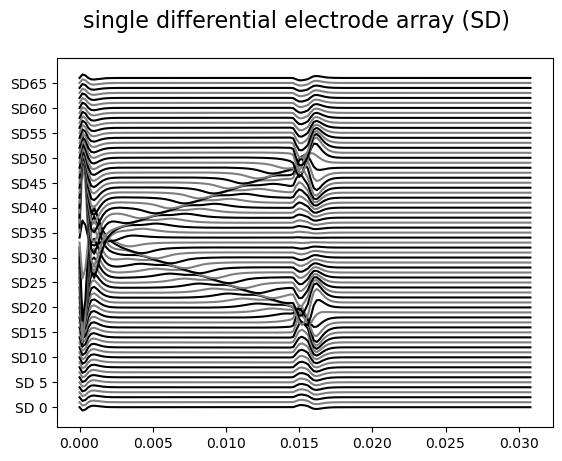

In [32]:
fig, ax =  tools.plotSum_df(sim_res.sum_df_SD, delta=0.03)
_ = ax.set_yticks(ax.get_yticks()[::5], minor=False)

## Repeating simulations

The exported configuration "\<project_dir\>/config.json" can be used to deterministically repeat 
a simulation setup as demonstrated below. 
The user could also choose to configure the model in the json file format instead of 
using python code as demonstrated within this document. However that is not the scope
of this document.

In [33]:
simJobs_repeat = sim_infrastructure.simJobsByModelConfig(config = "./introduction_output/demo_motor_unit/config.json"
                                   , project_dir="./introduction_output/demo_motor_unit_repeat"
            , create_project_dir=True, force_project_overwrite=True  )
simJobs_repeat.execute_all()

df_npz = tools.generate_df_sim_res_muscles(
    glob.glob("./introduction_output/demo_motor_unit_repeat/**/*.npz")
)
sim_res_repeat =  tools.npz_sEMG_sim_results(
      sim_project_dir = "./introduction_output/demo_motor_unit_repeat/"
    , npz_file_df     = df_npz[df_npz.unique_idx_motor_unit == 0]
    , idx_muscle      = 0
    , idx_motor_unit  = 0)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Calculating the difference between the repeated simulation and the previous result leads to:

In [34]:
(sim_res_repeat.sum_df_SD - sim_res.sum_df_SD).sum().sum()

0.0

# References

Merletti, R et al. “Modeling of surface myoelectric signals--Part I: Model implementation.” IEEE transactions on bio-medical engineering vol. 46,7 (1999): 810-20. doi:10.1109/10.771190

Mechtenberg, M and Schneider, A (2023) "A method for the estimation of a motor unit innervation zone center evaluated with a computational sEMG model" Frontiers in Neurorobotics. in rewiew.